In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall, MLP
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

# Guiding conditional cell diffusion process
We now exam a cell differentiation and development model from _Quantifying the Waddington landscape and biological paths for development and differentiation. Wang et.al._, which is a two-dimensional diffusion process governed by the pair of 1D SDEs:
$$
\mathrm{d}X_{t,1} = \left\{\frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} + \frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} - X_{t,1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,1} \\
\mathrm{d}X_{t,2} = \left\{\frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} + \frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} - X_{t,2}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a highly nonlinear process with no closed-form solution of conditional bridges. We choose the linear auxiliary process as:
$$
\mathrm{d}\tilde{X}_{t,1} = - \tilde{X}_{t,1}\mathrm{d}t + \sigma\mathrm{d}W_{t,1}\\
\mathrm{d}\tilde{X}_{t,2} = - \tilde{X}_{t,2}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a 2D Ornstein-Uhlenbeck process.

### Conditioning on normal events

In [5]:
dim = 2
T = 4.0
dt = 1.0 / 100

params = {
    "alpha": 1. / 16.,
    "sigma": 0.1
}

seed = 42
u = jnp.array([0.1, -0.1])
v = jnp.array([2.0, -0.1])
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [9]:
W = WienerProcess(T, dt, shape=(dim,))
X = CellDiffusionProcess(params, T, dim)
X_tilde = CellDiffusionAuxProcess(params, T, dim)

X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    L0=jnp.eye(dim), 
    Sigma0=jnp.eye(dim)*1e-10, 
    ts=jnp.arange(0, T + dt, dt),
)

X_solver = Euler(sde=X, W=W)
X_tilde_solver = Euler(sde=X_tilde, W=W)
X_circ_solver = Euler(sde=X_circ, W=W)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}>

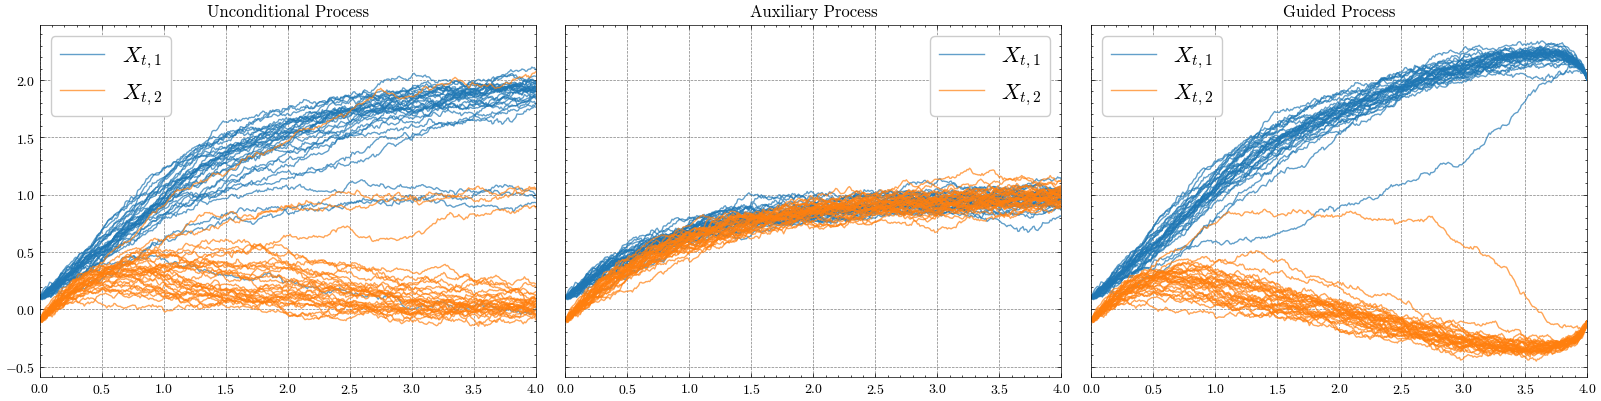

In [13]:
batch_size = 32
X_path = X_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
X_tilde_path = X_tilde_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
X_circ_path = X_circ_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_endpoint=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(X_path, ax=axes[0], label=["$X_{t,1}$", "$X_{t,2}$"], title="Unconditional Process")
plot_sample_path(X_tilde_path, ax=axes[1], label=["$X_{t,1}$", "$X_{t,2}$"], title="Auxiliary Process")
plot_sample_path(X_circ_path, ax=axes[2], label=["$X_{t,1}$", "$X_{t,2}$"], title="Guided Process")

In [14]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20, 20),
    activation="tanh",
)

In [18]:
train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_4T",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [19]:
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    neural_net=neural_net,
    config=train_config
)
X_diamond.initialize_path_solver(W)

In [20]:
losses = X_diamond.train(mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -196.64867
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -211.28491
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -214.55492
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -215.36255
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -215.70676
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -215.92148
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -216.01277
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -216.03214
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -216.13663
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -216.04576
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T/epoch_10


In [30]:
pCN_config = {
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(X_circ=X_circ, config=pCN_config)
pCN_model.initialize_solver(W)
pCN_logs, pCN_result = pCN_model.run(log_every=100)

Running pCN with log every 100:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 29.28%


Text(0.5, 1.0, 'MCMC Log-likelihood')

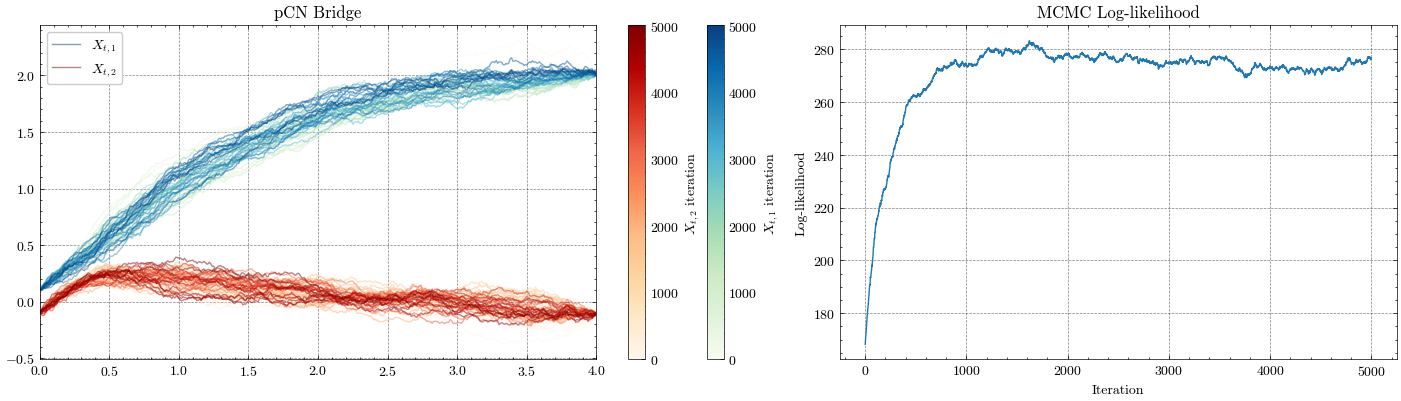

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")
plot_mcmc_sample_path(pCN_logs, ax=ax[0], label=["$X_{t,1}$", "$X_{t,2}$"], title="pCN Bridge", alpha=0.5, n_iters=5000)

ax[1].plot(jnp.mean(pCN_result.log_lls, axis=-1))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")
ax[1].set_title("MCMC Log-likelihood")

In [38]:
sm_train_config = {
    "save_name": "cell_model_1e-1sigma_4T",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 16,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [46]:
neural_net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 32, 32, 32),
    t_emb_dim=32,
    t_emb_max_period=100.0,
    t_emb_scaling=100.0,
    norm="batch"
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(X, u, v, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(W)
losses = sm_reverse_bridge.train(mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 398.92789
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 396.51559
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 395.19290
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 394.89685
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 393.72888
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 393.45609
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 393.25684
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 393.11948
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 392.94739
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 392.61594
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model_1e-1sigma_4T/epoch_10


In [48]:
Y_star = sm_reverse_bridge.build_reversed_bridge()
Y_star_solver = Euler(sde=Y_star, W=W)
Y_star_path = Y_star_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_endpoint=u)

In [49]:
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

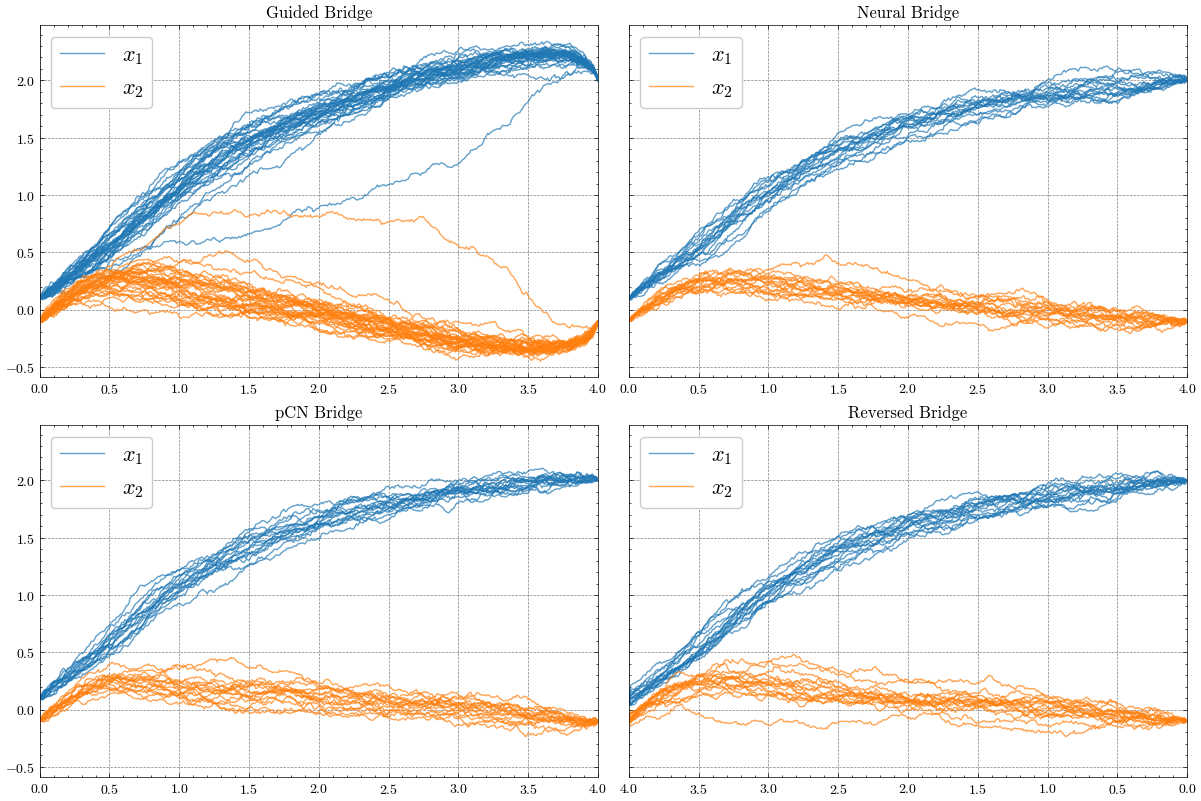

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(X_circ_path, ax=ax[0, 0], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(X_diamond_path, ax=ax[0, 1], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path, ax=ax[1, 0], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(Y_star_path, ax=ax[1, 1], label=["$x_1$", "$x_2$"], title="Reversed Bridge")
ax[1, 1].invert_xaxis()

### Conditioning on rare events

In [23]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
# v = jnp.array([2.0, -0.1], dtype=dtype)
v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [24]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

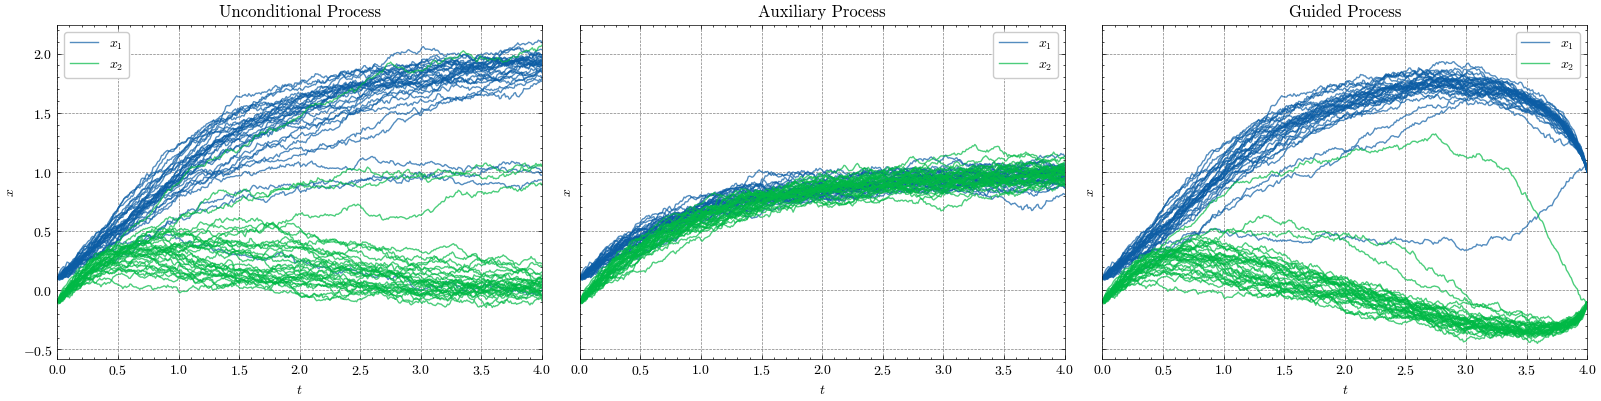

In [25]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], label=["$x_1$", "$x_2$"], title="Guided Process")

In [27]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20, 20),
    activation="tanh",
)

train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_4T_rare_event",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [28]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -7.60846
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_1


Epoch 2:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -20.09893
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_2


Epoch 3:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -27.93953
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_3


Epoch 4:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -39.13037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_4


Epoch 5:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -45.16885
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_5


Epoch 6:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -48.49503
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_6


Epoch 7:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -49.30443
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_7


Epoch 8:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -50.82123
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_8


Epoch 9:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -51.55861
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_9


Epoch 10:   0%|          | 0/200 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -51.78660
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_4T_rare_event/epoch_10


In [29]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [30]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN()

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 14.20%


Text(0.5, 0.98, 'Conditioning on Rare Events')

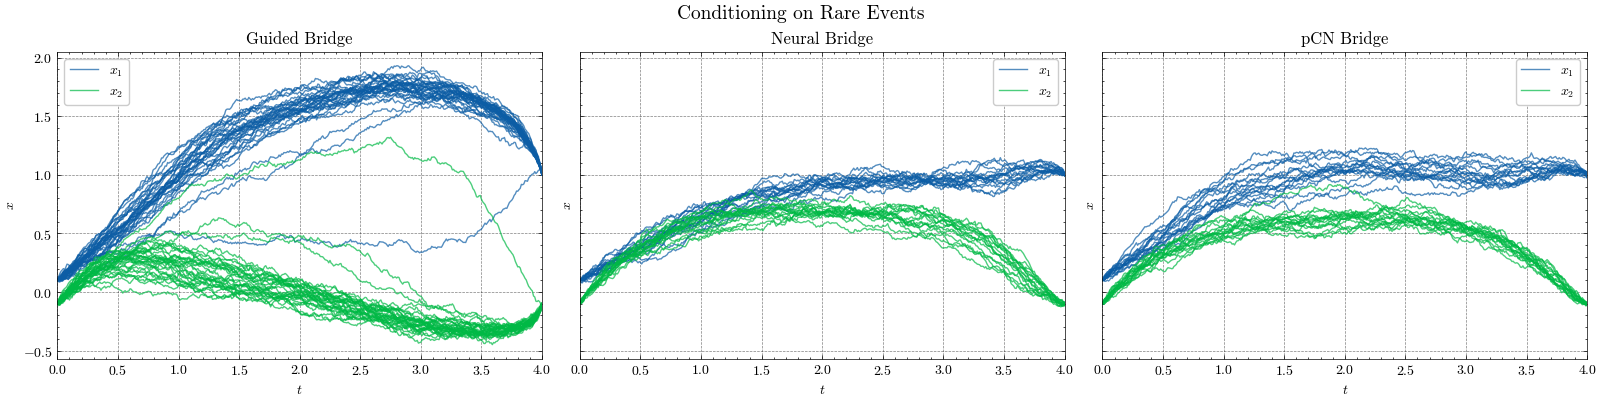

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path, ax=ax[2], label=["$x_1$", "$x_2$"], title="pCN Bridge")
fig.suptitle("Conditioning on Rare Events", fontsize=14)

### Multi-modality

In [32]:
dim = 2
T = 5.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([-1.0, -1.0], dtype=dtype)
v = jnp.array([-1.0, -1.0], dtype=dtype) # The event that cause the multi-modality

In [33]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

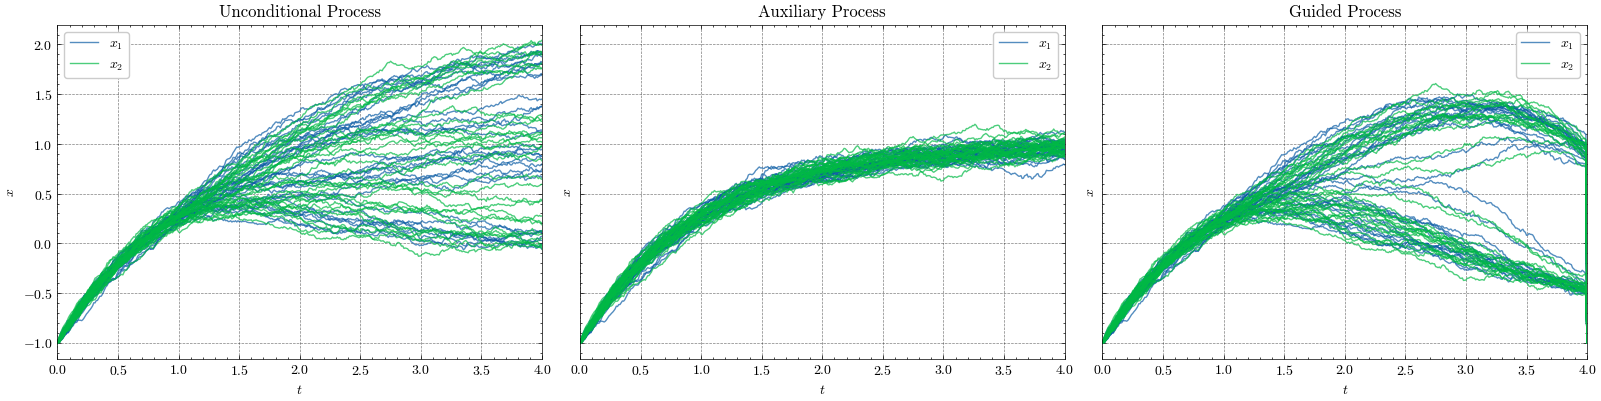

In [34]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], label=["$x_1$", "$x_2$"], title="Guided Process")

In [35]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20, 20),
    activation="tanh",
)

train_config = {
    "save_name": "cell_model_tanh_1e-1sigma_5T_multi_modality",
    "seed": seed,
    "learning_rate": 4e-4,
    "batch_size": 64,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [36]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 7.17635
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 6.14389
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 4.61296
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 3.70136
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 3.36821
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 3.12460
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 3.09145
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 3.03658
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 2.98646
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 2.99292
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_tanh_1e-1sigma_5T_multi_modality/epoch_10


In [37]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 1,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 35.96%


Text(0.5, 1.0, 'MCMC Log-likelihood')

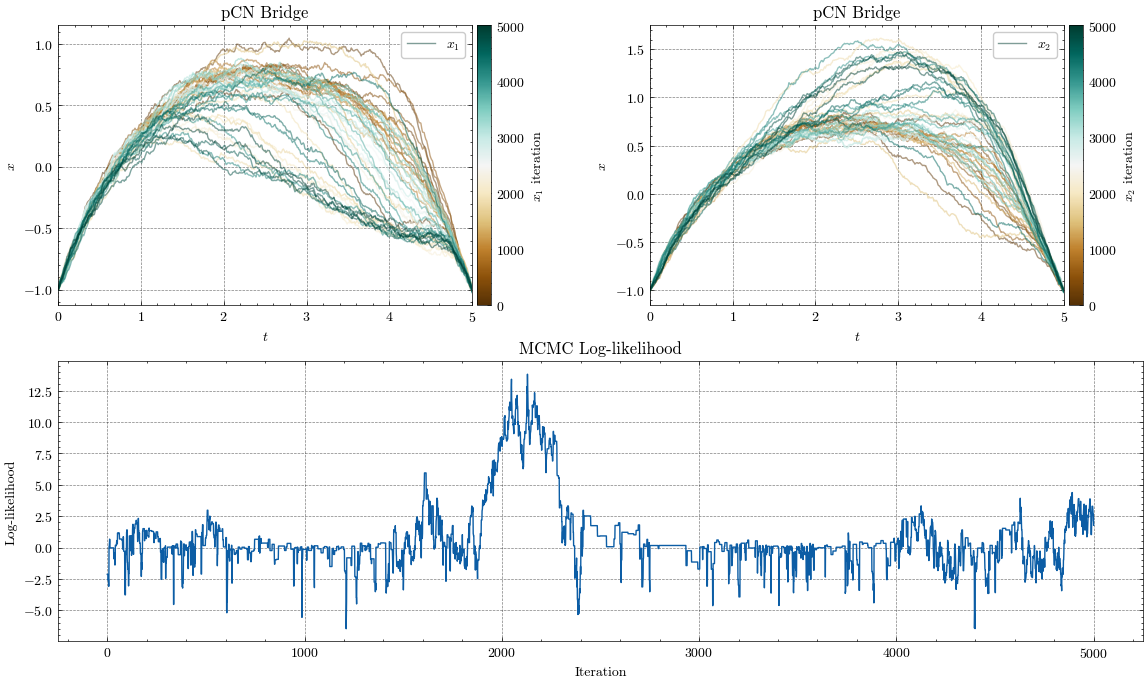

In [38]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

plot_mcmc_sample_path(pCN_result, plot_dim=[0], ax=ax1, cmap="BrBG", label="$x_1$", title="pCN Bridge", alpha=0.5, n_iters=5000)
plot_mcmc_sample_path(pCN_result, plot_dim=[1], ax=ax2, cmap="BrBG", label="$x_2$", title="pCN Bridge", alpha=0.5, n_iters=5000)

ax3.plot(pCN_result[-1].log_lls)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Log-likelihood") 
ax3.set_title("MCMC Log-likelihood")

In [39]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=64)

In [40]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 64,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN()

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 45.58%


Text(0.5, 0.98, 'Conditioning on Events that cause Multi-modality')

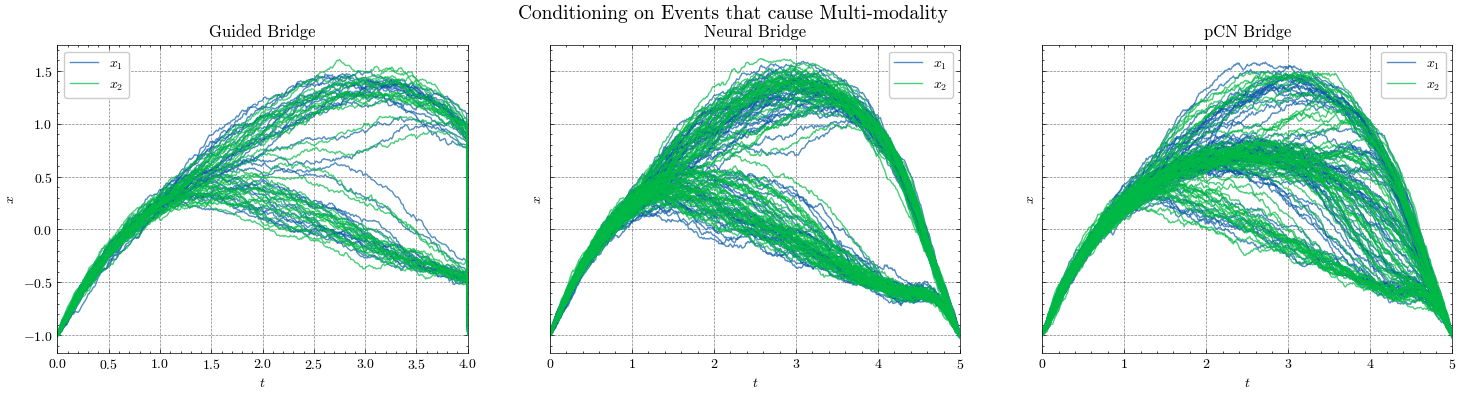

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
plot_sample_path(guided_path, ax=ax[0], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path, ax=ax[2], label=["$x_1$", "$x_2$"], title="pCN Bridge")
fig.suptitle("Conditioning on Events that cause Multi-modality", fontsize=14)
